In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()


In [4]:
#Get number of actions from gym action space
#n_actions = env.action_space.n
n_action_features = 5
n_state_features = 9
n_input_features = n_action_features + n_state_features


def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [5]:

class TrainConfig():
    def __init__(self, train_interval=128, batch_size=128, clear_memory=False, lr=0.01):
        self.train_interval = train_interval
        self.batch_size = batch_size
        self.clear_memory = clear_memory
        self.lr = lr
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [12]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(clear_memory=False, batch_size=128, train_interval=128)):
    #torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    env = Env(df)
    #memory = ReplayMemory(10000)
    
    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    
    
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        guesses = []
        for t in count():
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            
            
            #MODEL
            if t == 0 and model.startword:
                chosen_word = model.startword
            else:
                chosen_word = env.sample_word_matching_current_history()
            #/MODEL
            
            
            guesses.append(chosen_word)
            print(f'------guess {t} {guesses[-1]} -------')
            history, reward, done = env.step(chosen_word)
            episode_memory.append(reward)
                       
            print(f'reward {reward} done {done} ')
            
            if done:
                episode_durations.append(t + 1)
                episode_reward = sum(episode_memory)
                print(f'episode {i_episode} finished.  reward {t + 1} {episode_reward} {steps_done}')
                episode_rewards.append(episode_reward)
                break

    print('Complete')
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

=========================episode 0 lorry======================
------guess 0 syrah -------
reward 3.0 done False 
------guess 1 mirly -------
reward 2.0 done False 
------guess 2 lurry -------
reward 3.0 done False 
------guess 3 lorry -------
reward 2.0 done True 
episode 0 finished.  reward 4 10.0 4
=========================episode 1 quote======================
------guess 0 gurry -------
reward 2.0 done False 
------guess 1 fumet -------
reward 2.0 done False 
------guess 2 suets -------
reward 1.0 done False 
------guess 3 quite -------
reward 3.0 done False 
------guess 4 quate -------
reward 0 done False 
------guess 5 quote -------
reward 2.0 done True 
episode 1 finished.  reward 6 10.0 10
=========================episode 2 smelt======================
------guess 0 snoot -------
reward 4.0 done False 
------guess 1 swept -------
reward 2.0 done False 
------guess 2 sleet -------
reward 1.0 done False 
------guess 3 smelt -------
reward 3.0 done True 
episode 2 finished.  reward

------guess 3 taals -------
reward 0 done False 
------guess 4 koala -------
reward 5.0 done True 
episode 24 finished.  reward 5 10.0 119
=========================episode 25 spare======================
------guess 0 bulks -------
reward 1.0 done False 
------guess 1 pesto -------
reward 2.0 done False 
------guess 2 aspie -------
reward 2.0 done False 
------guess 3 shape -------
reward 2.0 done False 
------guess 4 spare -------
reward 3.0 done True 
episode 25 finished.  reward 5 10.0 124
=========================episode 26 vault======================
------guess 0 sloom -------
reward 1.0 done False 
------guess 1 bezel -------
reward 0 done False 
------guess 2 kalpa -------
reward 2.0 done False 
------guess 3 lawin -------
reward 0 done False 
------guess 4 fault -------
reward 5.0 done False 
------guess 5 gault -------
reward 0 done True 
episode 26 finished.  reward 6 8.0 130
=========================episode 27 tipsy======================
------guess 0 faked -------
reward 0 

------guess 2 logan -------
reward 5.0 done False 
------guess 3 organ -------
reward 3.0 done True 
episode 49 finished.  reward 4 10.0 234
=========================episode 50 laden======================
------guess 0 arbas -------
reward 1.0 done False 
------guess 1 vocal -------
reward 1.0 done False 
------guess 2 flamm -------
reward 0 done False 
------guess 3 laten -------
reward 6.0 done False 
------guess 4 laden -------
reward 2.0 done True 
episode 50 finished.  reward 5 10.0 239
=========================episode 51 palsy======================
------guess 0 dight -------
reward 0 done False 
------guess 1 canso -------
reward 4.0 done False 
------guess 2 palsy -------
reward 6.0 done True 
episode 51 finished.  reward 3 10.0 242
=========================episode 52 faint======================
------guess 0 piper -------
reward 1.0 done False 
------guess 1 kliks -------
reward 1.0 done False 
------guess 2 faint -------
reward 8.0 done True 
episode 52 finished.  reward 3 10

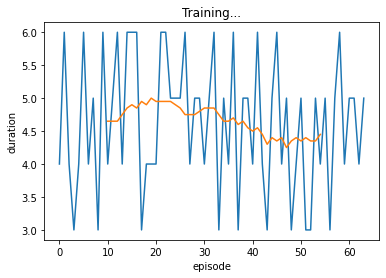

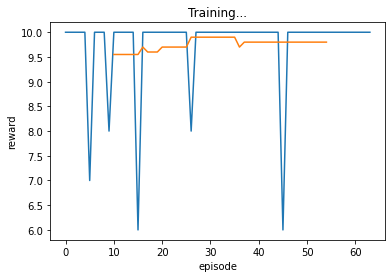

In [13]:
plot_all(*run_experiment(
    model=ModelConfig(name='naive', startword=None, target_list_only=False),
    num_episodes=64
    ))


In [ ]:
plot_all(*run_experiment(
    model=ModelConfig(name='naive', startword=None, target_list_only=True),
    num_episodes=64
    ))

=========================episode 0 lorry======================
------guess 0 syrah -------
reward 3.0 done False 
------guess 1 mirly -------
reward 2.0 done False 
------guess 2 lurry -------
reward 3.0 done False 
------guess 3 lorry -------
reward 2.0 done True 
episode 0 finished.  reward 4 10.0 4
=========================episode 1 quote======================
------guess 0 gurry -------
reward 2.0 done False 
------guess 1 fumet -------
reward 2.0 done False 
------guess 2 suets -------
reward 1.0 done False 
------guess 3 quite -------
reward 3.0 done False 
------guess 4 quate -------
reward 0 done False 
------guess 5 quote -------
reward 2.0 done True 
episode 1 finished.  reward 6 10.0 10
=========================episode 2 smelt======================
------guess 0 snoot -------
reward 4.0 done False 
------guess 1 swept -------
reward 2.0 done False 
------guess 2 sleet -------
reward 1.0 done False 
------guess 3 smelt -------
reward 3.0 done True 
episode 2 finished.  reward

In [ ]:
plot_all(*run_experiment(
    model=ModelConfig(name='naive', startword='roate', target_list_only=True),
    num_episodes=64
    ))


=========================episode 0 lorry======================
------guess 0 roate -------
reward 3.0 done False 
------guess 1 sopor -------
reward 0 done False 
------guess 2 dorky -------
reward 3.0 done False 
------guess 3 forby -------
reward 0 done False 
------guess 4 wormy -------
reward 0 done False 
------guess 5 horny -------
reward 0 done True 
episode 0 finished.  reward 6 0 6
=========================episode 1 palsy======================
------guess 0 roate -------
reward 1.0 done False 
------guess 1 bambi -------
reward 1.0 done False 
------guess 2 cawks -------
reward 1.0 done False 
------guess 3 palsy -------
reward 7.0 done True 
episode 1 finished.  reward 4 0 10
=========================episode 2 prize======================
------guess 0 roate -------
reward 3.0 done False 
------guess 1 fibre -------
reward 1.0 done False 
------guess 2 crime -------
reward 2.0 done False 
------guess 3 grise -------
reward 0 done False 
------guess 4 drive -------
reward 0 don

------guess 4 cowry -------
reward 0 done False 
------guess 5 dowry -------
reward 2.0 done True 
episode 24 finished.  reward 6 0 119
=========================episode 25 burnt======================
------guess 0 roate -------
reward 2.0 done False 
------guess 1 nitry -------
reward 1.0 done False 
------guess 2 grunt -------
reward 3.0 done False 
------guess 3 turnt -------
reward 2.0 done False 
------guess 4 burnt -------
reward 2.0 done True 
episode 25 finished.  reward 5 0 124
=========================episode 26 spank======================
------guess 0 roate -------
reward 2.0 done False 
------guess 1 spazz -------
reward 4.0 done False 
------guess 2 spans -------
reward 2.0 done False 
------guess 3 spang -------
reward 0 done False 
------guess 4 spank -------
reward 2.0 done True 
episode 26 finished.  reward 5 0 129
=========================episode 27 plush======================
------guess 0 roate -------
reward 0 done False 
------guess 1 pulps -------
reward 5.0 done

------guess 4 towel -------
reward 4.0 done True 
episode 48 finished.  reward 5 0 234
=========================episode 49 enter======================
------guess 0 roate -------
reward 3.0 done False 
------guess 1 erect -------
reward 2.0 done False 
------guess 2 enter -------
reward 5.0 done True 
episode 49 finished.  reward 3 0 237
=========================episode 50 acorn======================
------guess 0 roate -------
reward 3.0 done False 
------guess 1 maror -------
reward 0 done False 
------guess 2 aspro -------
reward 2.0 done False 
------guess 3 abord -------
reward 1.0 done False 
------guess 4 acorn -------
reward 4.0 done True 
episode 50 finished.  reward 5 0 242
=========================episode 51 terra======================
------guess 0 roate -------
reward 4.0 done False 
------guess 1 water -------
reward 0 done False 
------guess 2 avert -------
reward 1.0 done False 
------guess 3 terra -------
reward 5.0 done True 
episode 51 finished.  reward 4 0 246
=====

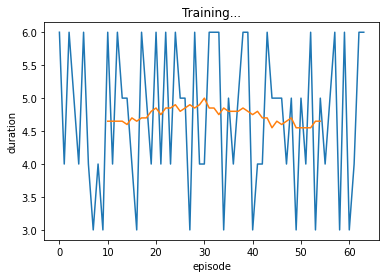

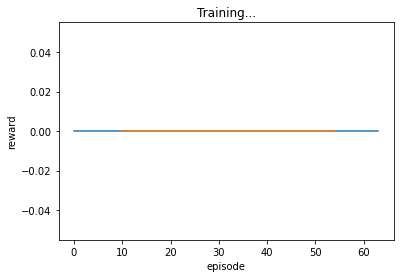

In [10]:
plot_all(*run_experiment(
    model=ModelConfig(name='naive', startword='roate', target_list_only=False),
    num_episodes=64
    ))


=========================episode 0 lorry======================
------guess 0 oater -------
reward 2.0 done False 
------guess 1 porin -------
reward 2.0 done False 
------guess 2 gorms -------
reward 0 done False 
------guess 3 corby -------
reward 2.0 done False 
------guess 4 worry -------
reward 2.0 done False 
------guess 5 lorry -------
reward 2.0 done True 
episode 0 finished.  reward 6 0 6
=========================episode 1 marsh======================
------guess 0 oater -------
reward 3.0 done False 
------guess 1 rails -------
reward 1.0 done False 
------guess 2 saury -------
reward 0 done False 
------guess 3 marsh -------
reward 6.0 done True 
episode 1 finished.  reward 4 0 10
=========================episode 2 milky======================
------guess 0 oater -------
reward 0 done False 
------guess 1 bilgy -------
reward 6.0 done False 
------guess 2 silly -------
reward 0 done False 
------guess 3 milky -------
reward 4.0 done True 
episode 2 finished.  reward 4 0 14
====

------guess 1 draco -------
reward 0 done False 
------guess 2 poral -------
reward 4.0 done False 
------guess 3 romal -------
reward 1.0 done False 
------guess 4 royal -------
reward 2.0 done True 
episode 26 finished.  reward 5 0 122
=========================episode 27 wheel======================
------guess 0 oater -------
reward 2.0 done False 
------guess 1 yewen -------
reward 2.0 done False 
------guess 2 sweel -------
reward 3.0 done False 
------guess 3 wheel -------
reward 3.0 done True 
episode 27 finished.  reward 4 0 126
=========================episode 28 magma======================
------guess 0 oater -------
reward 2.0 done False 
------guess 1 baisa -------
reward 2.0 done False 
------guess 2 vanda -------
reward 0 done False 
------guess 3 palla -------
reward 0 done False 
------guess 4 jaffa -------
reward 0 done False 
------guess 5 kacha -------
reward 0 done True 
episode 28 finished.  reward 6 0 132
=========================episode 29 gamut===================

------guess 2 sculp -------
reward 2.0 done False 
------guess 3 blunk -------
reward 3.0 done False 
------guess 4 flung -------
reward 4.0 done True 
episode 51 finished.  reward 5 0 245
=========================episode 52 stunk======================
------guess 0 oater -------
reward 1.0 done False 
------guess 1 musit -------
reward 2.0 done False 
------guess 2 studs -------
reward 3.0 done False 
------guess 3 stull -------
reward 0 done False 
------guess 4 stuff -------
reward 0 done False 
------guess 5 stuck -------
reward 2.0 done True 
episode 52 finished.  reward 6 0 251
=========================episode 53 swish======================
------guess 0 oater -------
reward 0 done False 
------guess 1 pilum -------
reward 1.0 done False 
------guess 2 whiny -------
reward 3.0 done False 
------guess 3 swish -------
reward 6.0 done True 
episode 53 finished.  reward 4 0 255
=========================episode 54 queer======================
------guess 0 oater -------
reward 4.0 done

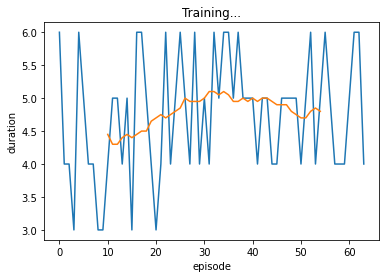

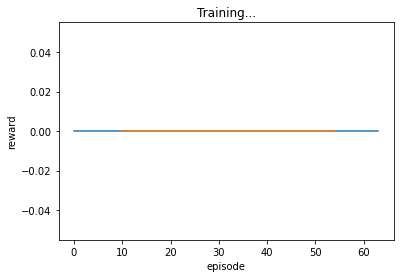

In [11]:
plot_all(*run_experiment(
    model=ModelConfig(name='naive', startword='oater', target_list_only=True),
    num_episodes=64
    ))
